In [ ]:
#!unzip "/content/drive/MyDrive/Dataset.zip" -d "/content/drive/MyDrive/Data_set/" #unzipping the dataset files

#Install and configuring pyspark in colab

In [ ]:
!pip install pyspark  

In [ ]:
#Importing libraries that is required for analysis
from pyspark.ml.stat import Correlation
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as f

In [ ]:
#pyspark session 
Spark_model=SparkSession.builder.appName('spark_file').getOrCreate()

In [ ]:
#Reading csv files
df=Spark_model.read.option("header", "true").option("inferSchema",True).csv("/content/drive/MyDrive/Data_set/*.csv")

In [ ]:
df.show() #showing data that is present in the dataset 

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+------------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-------------

In [ ]:
df=df.fillna(0) #removing null values

In [ ]:
#Removing the spaces in the names of the columns and replace with underscore
from pyspark.sql import functions as F
new_df = df.select([F.col(col).alias(col.replace(' ', '_')) for col in df.columns])

In [ ]:

new_df.show() #showing the new dataframe 

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+------------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-------------

#Queries 

In [ ]:
new_df.createOrReplaceTempView("benign_Table") #creating table to store the values of the csv values into table 

In [ ]:
#queries for visulising all the attributes using pyspark
Spark_model.sql("select * from benign_Table").show()

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+------------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-------------

In [ ]:
#query--1
#In this query, average of the forward and backward packets according to protocol is calculated.
fwd_pkts=Spark_model.sql("select Avg(Tot_Fwd_Pkts) as bmax, \
     Avg(Tot_Bwd_Pkts) as bmin, \
     Protocol from benign_Table where \
     Protocol NOT IN (10) and Tot_Bwd_Pkts>=5 group by Protocol order by bmin desc")
fwd_pkts.show()

+------------------+------------------+--------+
|              bmax|              bmin|Protocol|
+------------------+------------------+--------+
| 30.95109439124487|41.512995896032834|      17|
|16.921327691347237|25.233711675294323|       6|
| 7.347222222222222| 7.347222222222222|       0|
+------------------+------------------+--------+



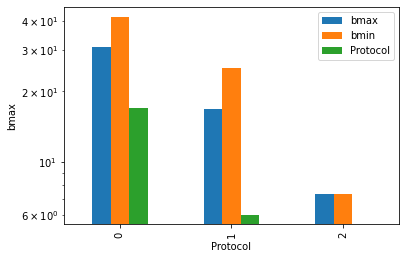

In [ ]:
#Visualization of the query results.
pkts=fwd_pkts.toPandas()
pkts.plot( logy=True, xlabel='Protocol', ylabel="bmax", kind='bar')

In [ ]:
#Query--2
#In this query, sum of backward IAT max and min values are filtered according to dst port and label values. 
min_max_values=Spark_model.sql("select sum(Bwd_IAT_Max) as max_values, \
     sum(Bwd_IAT_Min) as min_values, \
     Label from benign_Table where \
     Dst_Port IN (0, 10) and Bwd_IAT_Min<=300 group by Label order by min_values desc")
min_max_values.show()

+----------+----------+----------------+
|max_values|min_values|           Label|
+----------+----------+----------------+
|    1520.0|    1284.0|          Benign|
|       0.0|       0.0|Brute Force -Web|
|       0.0|       0.0|             Bot|
+----------+----------+----------------+



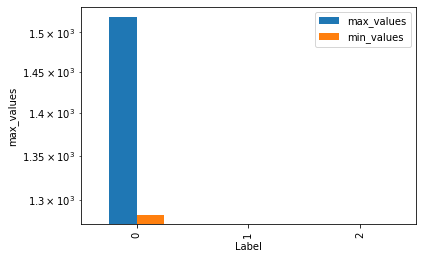

In [ ]:
#Visualization of the above query. 
min_max=min_max_values.toPandas()
min_max.plot( logy=True, xlabel='Label', ylabel="max_values", kind='bar')

#Analytical methods 

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

+---------------+
|TotLen_Fwd_Pkts|
+---------------+
|           2333|
|              0|
|            372|
|              0|
|            599|
|              0|
|            445|
|              0|
|            968|
|              0|
|           3419|
|              0|
|           2140|
|              0|
|              0|
|              0|
|           5792|
|              0|
|          54442|
|              0|
+---------------+
only showing top 20 rows



Text(0.5, 6.79999999999999, 'TotLen_Fwd_Pkts')

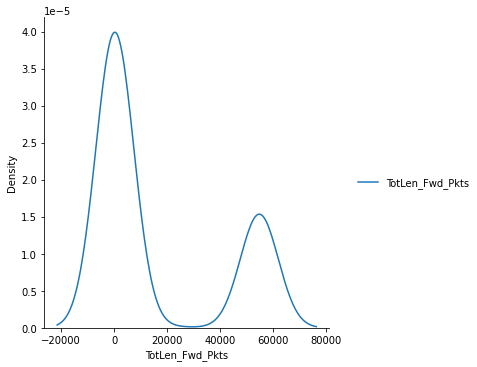

In [ ]:
#Analytical_methods--01
#KDE distribution plot for the TotLen_Fwd_Pkts
fwd_pkts=new_df.filter("Protocol= 6").filter("Label='Brute Force -Web'").select('TotLen_Fwd_Pkts')
fwd_pkts.show()
fwd_pkts_kde=fwd_pkts.toPandas()
sns.displot(fwd_pkts_kde, kind='kde')
plt.xlabel('TotLen_Fwd_Pkts')

In [ ]:
#Analytical_methods--02
#Statistical analysis of the attributes that will be used for designing the models
new_df.select('Protocol','Fwd_Pkt_Len_Max', 
              'Fwd_Pkt_Len_Min','Subflow_Fwd_Pkts', 
              'Subflow_Fwd_Byts', 'Fwd_Act_Data_Pkts',
              'Fwd_Seg_Size_Min').describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Protocol,7340018,7.972267097982593,4.3434158568247305,0,17
Fwd_Pkt_Len_Max,7340018,238.01234710868556,344.25881122072633,0,64440
Fwd_Pkt_Len_Min,7340018,8.01926970751298,21.726426423991615,0,1460
Subflow_Fwd_Pkts,7340018,32.943601500704766,1854.0592777044114,1,309629
Subflow_Fwd_Byts,7340018,1293.6394789495066,60613.5243447207,0,9908128
Fwd_Act_Data_Pkts,7340018,29.387298232783625,1852.923607190166,0,309628
Fwd_Seg_Size_Min,7340018,20.421886158862282,8.509632803828069,0,56


In [ ]:
#Analytical_methods--03
#finding the kurtosis and skewness of the attributes
new_df.select(f.skewness(new_df['TotLen_Fwd_Pkts']), f.skewness(new_df['Subflow_Fwd_Byts'])).show()
new_df.select(f.skewness(new_df['Fwd_Act_Data_Pkts']), f.skewness(new_df[ 'Fwd_Seg_Size_Min'])).show()

+-------------------------+--------------------------+
|skewness(TotLen_Fwd_Pkts)|skewness(Subflow_Fwd_Byts)|
+-------------------------+--------------------------+
|        71.71273326962171|         71.71273326962171|
+-------------------------+--------------------------+

+---------------------------+--------------------------+
|skewness(Fwd_Act_Data_Pkts)|skewness(Fwd_Seg_Size_Min)|
+---------------------------+--------------------------+
|          70.36080451891563|       0.25899129786902886|
+---------------------------+--------------------------+



#Machine learning models 

In [ ]:
creating_features=VectorAssembler(
    inputCols=['Protocol','Fwd_Pkt_Len_Max', 
              'Fwd_Pkt_Len_Min','Subflow_Fwd_Pkts', 
              'Subflow_Fwd_Byts', 'Fwd_Act_Data_Pkts',
              'Fwd_Seg_Size_Min'], 
              outputCol='Feature_Values')

In [ ]:
#tranforming the data into vsctor form 
vector_Values_for_features =creating_features.transform(new_df)
data_df=vector_Values_for_features.select(['Feature_Values', 'Label'])
data_df.show(5)

+--------------------+------+
|      Feature_Values| Label|
+--------------------+------+
|       (7,[3],[3.0])|Benign|
|       (7,[3],[3.0])|Benign|
|       (7,[3],[3.0])|Benign|
|[6.0,744.0,0.0,15...|Benign|
|[6.0,744.0,0.0,14...|Benign|
+--------------------+------+
only showing top 5 rows



In [ ]:
#converting categorical values of target into unqiue labels in the decimal format 

converting_target_values=StringIndexer(inputCol="Label", outputCol='target')
data_df=converting_target_values.fit(data_df).transform(data_df)
data_df.show(3)

+--------------+------+------+
|Feature_Values| Label|target|
+--------------+------+------+
| (7,[3],[3.0])|Benign|   0.0|
| (7,[3],[3.0])|Benign|   0.0|
| (7,[3],[3.0])|Benign|   0.0|
+--------------+------+------+
only showing top 3 rows



##RANDOM FOREST CLASSIFIER MODEL

In [ ]:
#Splitting dataset into training and testing 
train_df, test_df=data_df.randomSplit([0.75, 0.25])

In [ ]:
#Random forest classifier for taking decisions over the feature values
Random_model_for_featured_values = RandomForestClassifier(featuresCol = 'Feature_Values', labelCol='target')
random_model_fit=Random_model_for_featured_values.fit(train_df)

In [ ]:
#Fitting prediction values on the test data 
random_model_prediction_values=random_model_fit.transform(test_df)

In [ ]:
#Using Multiclassclassfier to evalute to values and suggest the acuracy and error rate of the models. 
result_on_test_data= MulticlassClassificationEvaluator(labelCol='target', predictionCol="prediction")
evalutor_values= result_on_test_data.evaluate(random_model_prediction_values)

In [ ]:
#Training Score
print(evalutor_values*100)

84.19347370930294


In [ ]:
#Error values 
Error=(1-evalutor_values)
print(Error)

0.15806526290697065


#Converting .ipynb file to HTML 

In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html AHY14185_03.ipynb